In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import Adam
from imblearn.under_sampling import NearMiss
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve

In [2]:
df = pd.read_csv('pairs_with_embeddings.csv')

In [4]:
need_emb_cols = [f'need_emb_{i}' for i in range(3072)]
res_emb_cols = [f'res_emb_{i}' for i in range(3072)]

need_emb_cols = [f'need_emb_{i}' for i in range(3072)]
res_emb_cols = [f'res_emb_{i}' for i in range(3072)]

# Convert to NumPy arrays
need_embs = df[need_emb_cols].to_numpy()
res_embs = df[res_emb_cols].to_numpy()

# Compute cosine similarity row-wise
cos_sim = np.einsum('ij,ij->i', need_embs, res_embs) / (
    np.linalg.norm(need_embs, axis=1) * np.linalg.norm(res_embs, axis=1) + 1e-9
)

df['cosine_similarity'] = cos_sim

In [5]:
clusters = pd.read_csv('clusters.csv')
clusters.head()

,academic_resource_id,name
0,391,Cluster 1
1,321,Sociología_Prácticas
2,640,Cluster 2
3,225,Cluster 3
4,253,Cluster 4


In [6]:
merged = df.merge(clusters, on="academic_resource_id", how="left")
merged.head()

,need_id,need_name,need_description,need_expiration_date,need_created_at,need_internship,offer_name,offer_description,offer_semester,offer_company_year,...,res_emb_3064,res_emb_3065,res_emb_3066,res_emb_3067,res_emb_3068,res_emb_3069,res_emb_3070,res_emb_3071,cosine_similarity,name
0,1456,Investigación sobre los factores que inciden e...,De acuerdo a la temáticas sociales y en especi...,2019-08-04,2019-02-04 14:56:21.388586,True,Pasantía de College 1-2019,"Pasantía cocurricular de al menos 160 horas, d...",0.0,2019,...,-0.007797,-0.001040,0.019884,0.048212,0.003851,-0.013416,-0.028706,-0.004475,0.411339,College CCNN_Pasantías
1,5168,Apoyo y elaboración de plan de marketing para ...,La Fábrica de Renca es una entidad privada sin...,2024-03-20,2023-09-20 20:05:59.124840,True,Práctica Profesional 2-2023,Práctica profesional obligatoria de 320 horas ...,1.0,2023,...,-0.016801,0.006167,0.020265,0.039514,-0.000184,-0.006662,-0.018958,-0.012061,0.486173,Comercial_Prácticas
2,5152,Taller de Intervención para Programa de Calle ...,El curso taller de intervención tiene como pro...,2024-03-06,2023-09-06 19:51:21.818464,True,Taller de Intervención 2-2023,Taller de intervención dirigido a estudiantes ...,1.0,2023,...,-0.015388,0.011484,0.043120,0.049481,-0.002994,-0.004206,-0.003688,0.003104,0.782764,Trabajo Social_Práctica Inicial
3,3993,Diagnóstico de la población migrante en Renca ...,Desde el departamento de inclusión de la munic...,2022-09-22,2022-03-22 13:54:44.014323,True,Pasantía Verano-2021,"Pasantía cocurricular de al menos 160 horas, d...",2.0,2021,...,-0.005930,-0.006772,0.023805,0.045297,-0.006526,-0.019708,-0.012770,-0.005960,0.520189,Sociología_Prácticas
4,1907,Práctica Inicial Trabajo Social (II) - Unidad ...,Dentro de los objetivos de la Unidad Técnica d...,2020-02-19,2019-08-19 14:00:49.570249,True,Práctica Inicial II 2-2019,Segunda parte del taller de intervención dirig...,1.0,2019,...,-0.019662,0.010090,0.041508,0.046884,-0.001429,-0.001713,-0.005516,0.009988,0.396248,Trabajo Social_Práctica Inicial


In [7]:
df = merged
df = df.drop(columns=['academic_resource_description','need_id','need_name','need_description','need_expiration_date','need_created_at','offer_description','offer_name','offer_semester','offer_company_year','offer_expiration_date','offer_academic_resource_id','offer_created_at','academic_resource_name'])


In [8]:
df["need_internship"] = df["need_internship"].astype(int)

In [9]:
df[df.isnull().any(axis=1)].shape

(0, 6151)

In [10]:
df = df.dropna()

In [11]:
df.head()

,need_internship,academic_resource_id,academic_resource_level,academic_resource_type_id,has_match,need_emb_0,need_emb_1,need_emb_2,need_emb_3,need_emb_4,...,res_emb_3064,res_emb_3065,res_emb_3066,res_emb_3067,res_emb_3068,res_emb_3069,res_emb_3070,res_emb_3071,cosine_similarity,name
0,1,250,1,24,1,-0.011038,0.009111,-0.007517,-0.016986,0.014604,...,-0.007797,-0.001040,0.019884,0.048212,0.003851,-0.013416,-0.028706,-0.004475,0.411339,College CCNN_Pasantías
1,1,205,2,21,1,-0.008638,0.036582,-0.013364,-0.018138,0.011307,...,-0.016801,0.006167,0.020265,0.039514,-0.000184,-0.006662,-0.018958,-0.012061,0.486173,Comercial_Prácticas
2,1,582,1,21,1,0.010936,0.034407,-0.001854,0.008706,0.020503,...,-0.015388,0.011484,0.043120,0.049481,-0.002994,-0.004206,-0.003688,0.003104,0.782764,Trabajo Social_Práctica Inicial
3,1,330,2,24,1,-0.007967,0.022626,-0.013080,-0.032534,0.038485,...,-0.005930,-0.006772,0.023805,0.045297,-0.006526,-0.019708,-0.012770,-0.005960,0.520189,Sociología_Prácticas
4,1,286,1,21,1,0.002075,-0.005712,-0.003436,-0.047204,0.015465,...,-0.019662,0.010090,0.041508,0.046884,-0.001429,-0.001713,-0.005516,0.009988,0.396248,Trabajo Social_Práctica Inicial


In [12]:
# dummy categories columns
categorical_cols = ['academic_resource_id','academic_resource_level','academic_resource_type_id','name']
df_dummies = pd.get_dummies(df, columns=categorical_cols)
df_dummies

,need_internship,has_match,need_emb_0,need_emb_1,need_emb_2,need_emb_3,need_emb_4,need_emb_5,need_emb_6,need_emb_7,...,name_Psicología_Educacional,name_Psicología_General,name_Psicología_Organizacional,name_Psicología_Salud,name_Química_Fármacos,name_Sociales_Cuali,name_Sociología_Prácticas,name_Sustentabilidad,name_Trabajo Social_Práctica Inicial,name_Trabajo Social_Práctica Pro
0,1,1,-0.011038,0.009111,-0.007517,-0.016986,0.014604,-0.025290,0.002689,-0.001548,...,False,False,False,False,False,False,False,False,False,False
1,1,1,-0.008638,0.036582,-0.013364,-0.018138,0.011307,-0.034052,-0.023420,0.002229,...,False,False,False,False,False,False,False,False,False,False
2,1,1,0.010936,0.034407,-0.001854,0.008706,0.020503,0.007454,0.009723,0.027964,...,False,False,False,False,False,False,False,False,True,False
3,1,1,-0.007967,0.022626,-0.013080,-0.032534,0.038485,-0.009591,0.004437,0.004323,...,False,False,False,False,False,False,True,False,False,False
4,1,1,0.002075,-0.005712,-0.003436,-0.047204,0.015465,0.036516,-0.011592,0.012786,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85131,1,0,-0.047520,-0.003474,-0.009832,-0.009497,0.020467,0.001654,-0.020440,0.013607,...,False,False,False,False,False,False,False,False,False,False
85132,1,0,-0.047520,-0.003474,-0.009832,-0.009497,0.020467,0.001654,-0.020440,0.013607,...,False,False,False,False,False,False,False,False,False,False
85133,1,0,-0.047520,-0.003474,-0.009832,-0.009497,0.020467,0.001654,-0.020440,0.013607,...,False,False,False,False,False,False,False,False,False,False
85134,1,0,-0.047520,-0.003474,-0.009832,-0.009497,0.020467,0.001654,-0.020440,0.013607,...,False,False,False,False,False,False,False,False,False,False


In [13]:
df = df_dummies

In [14]:
X = df.drop(columns=['has_match'])
y = df['has_match']

In [15]:
# 6. Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# 5. Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Use the same scaler to transform the validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
nm = NearMiss()
X_train_resampled, y_train_resampled = nm.fit_resample(X_train_scaled, y_train)

In [18]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.0, 1: 1.0}

In [19]:
callbacks = [
    EarlyStopping(monitor="val_pr_auc", mode="max", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=2, verbose=1),
]


In [20]:
# 7. Build the model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # clasificación binaria
])

In [21]:
pr_auc = AUC(curve="PR", name="pr_auc")
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[Precision(name="precision"), Recall(name="recall"), AUC(name="auc"), pr_auc],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               852736    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [22]:
# 8. Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight={0:1, 1:5}
)

Epoch 1/100
2129/2129 [==============================] - 6s 3ms/step - loss: 0.7744 - precision: 0.0830 - recall: 0.5153 - auc: 0.6533 - pr_auc: 0.0912 - val_loss: 0.3333 - val_precision: 0.2542 - val_recall: 0.4792 - val_auc: 0.8530 - val_pr_auc: 0.3099 - lr: 1.0000e-04
Epoch 2/100
2129/2129 [==============================] - 5s 2ms/step - loss: 0.5359 - precision: 0.1751 - recall: 0.4365 - auc: 0.7777 - pr_auc: 0.2020 - val_loss: 0.2344 - val_precision: 0.3360 - val_recall: 0.5061 - val_auc: 0.8892 - val_pr_auc: 0.3859 - lr: 1.0000e-04
Epoch 3/100
2129/2129 [==============================] - 5s 2ms/step - loss: 0.4640 - precision: 0.2477 - recall: 0.4648 - auc: 0.8349 - pr_auc: 0.2680 - val_loss: 0.2128 - val_precision: 0.3417 - val_recall: 0.5966 - val_auc: 0.9147 - val_pr_auc: 0.4518 - lr: 1.0000e-04
Epoch 4/100
2129/2129 [==============================] - 5s 2ms/step - loss: 0.4108 - precision: 0.2916 - recall: 0.5270 - auc: 0.8777 - pr_auc: 0.3343 - val_loss: 0.1727 - val_precisi

In [24]:
y_probs = model.predict(X_val_scaled)
prec, rec, thresholds = precision_recall_curve(y_val, y_probs)
f2_scores = (5 * prec * rec) / (4 * prec + rec + 1e-9)
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
print("Best threshold for F2:", best_threshold)

267/267 [==============================] - 0s 638us/step
Best threshold for F2: 0.26494938


In [25]:
for thr in np.arange(best_threshold, 1.0, 0.01):
    y_pred = (y_probs >= thr).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f"Threshold: {thr:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Threshold: 0.26, Precision: 0.44, Recall: 0.82
Threshold: 0.27, Precision: 0.44, Recall: 0.81
Threshold: 0.28, Precision: 0.45, Recall: 0.81
Threshold: 0.29, Precision: 0.45, Recall: 0.81
Threshold: 0.30, Precision: 0.45, Recall: 0.81
Threshold: 0.31, Precision: 0.46, Recall: 0.80
Threshold: 0.32, Precision: 0.46, Recall: 0.80
Threshold: 0.33, Precision: 0.46, Recall: 0.79
Threshold: 0.34, Precision: 0.47, Recall: 0.79
Threshold: 0.35, Precision: 0.47, Recall: 0.78
Threshold: 0.36, Precision: 0.48, Recall: 0.78
Threshold: 0.37, Precision: 0.48, Recall: 0.78
Threshold: 0.38, Precision: 0.49, Recall: 0.78
Threshold: 0.39, Precision: 0.49, Recall: 0.78
Threshold: 0.40, Precision: 0.49, Recall: 0.78
Threshold: 0.41, Precision: 0.49, Recall: 0.78
Threshold: 0.42, Precision: 0.49, Recall: 0.77
Threshold: 0.43, Precision: 0.49, Recall: 0.77
Threshold: 0.44, Precision: 0.50, Recall: 0.77
Threshold: 0.45, Precision: 0.50, Recall: 0.76
Threshold: 0.46, Precision: 0.50, Recall: 0.75
Threshold: 0.

In [26]:
# 9. Evaluate the model
metrics = model.evaluate(X_test_scaled, y_test)
print(metrics)

267/267 [==============================] - 0s 833us/step - loss: 0.1169 - precision: 0.5260 - recall: 0.7483 - auc: 0.9594 - pr_auc: 0.6938      
[0.11685186624526978, 0.5259740352630615, 0.7482678890228271, 0.9594115018844604, 0.6938358545303345]


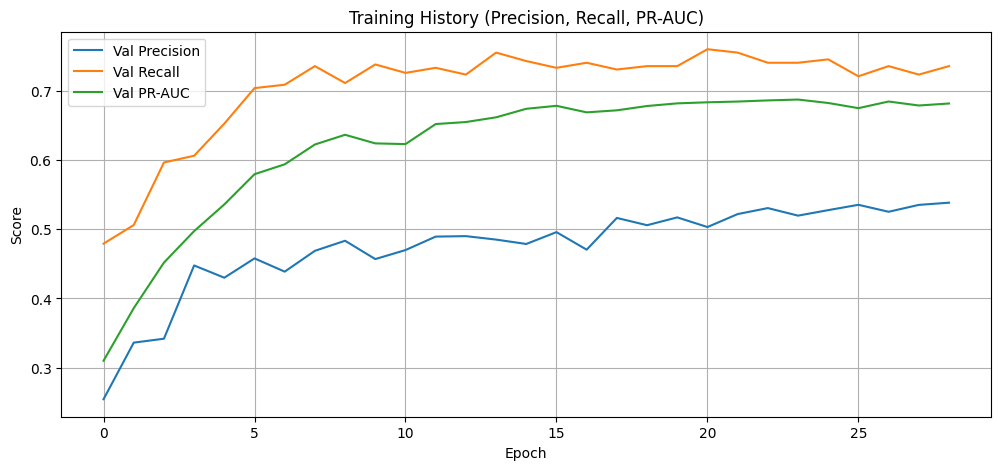

In [27]:
# 10. Plot training history
plt.figure(figsize=(12, 5))

# Precision
# plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')

# Recall
# plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')

# PR-AUC
# plt.plot(history.history['pr_auc'], label='Train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Val PR-AUC')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training History (Precision, Recall, PR-AUC)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
f2_scores = (5 * prec * rec) / (4 * prec + rec + 1e-9)  # F2 formula
best_idx = np.argmax(f2_scores)
best_thr = thresholds[best_idx]
print("Best threshold:", best_thr)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F2:", f2_scores[best_idx])

Best threshold: 0.26494938
Precision: 0.4413702239789196 Recall: 0.8190709046454768 F2: 0.6993736949277322


NameError: name 'y_true' is not defined

In [36]:
y_pred = (model.predict(X_test_scaled) > 0.72).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
pr_auc = average_precision_score(y_test, y_pred)
print("PR AUC:", pr_auc)

267/267 [==============================] - 0s 632us/step
[[7910  171]
 [ 142  291]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8081
           1       0.63      0.67      0.65       433

    accuracy                           0.96      8514
   macro avg       0.81      0.83      0.82      8514
weighted avg       0.96      0.96      0.96      8514

PR AUC: 0.43998605127022333


In [33]:
for thr in np.arange(best_threshold, 1.0, 0.01):
    y_pred = (y_probs >= thr).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f"Threshold: {thr:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Threshold: 0.26, Precision: 0.44, Recall: 0.82
Threshold: 0.27, Precision: 0.44, Recall: 0.81
Threshold: 0.28, Precision: 0.45, Recall: 0.81
Threshold: 0.29, Precision: 0.45, Recall: 0.81
Threshold: 0.30, Precision: 0.45, Recall: 0.81
Threshold: 0.31, Precision: 0.46, Recall: 0.80
Threshold: 0.32, Precision: 0.46, Recall: 0.80
Threshold: 0.33, Precision: 0.46, Recall: 0.79
Threshold: 0.34, Precision: 0.47, Recall: 0.79
Threshold: 0.35, Precision: 0.47, Recall: 0.78
Threshold: 0.36, Precision: 0.48, Recall: 0.78
Threshold: 0.37, Precision: 0.48, Recall: 0.78
Threshold: 0.38, Precision: 0.49, Recall: 0.78
Threshold: 0.39, Precision: 0.49, Recall: 0.78
Threshold: 0.40, Precision: 0.49, Recall: 0.78
Threshold: 0.41, Precision: 0.49, Recall: 0.78
Threshold: 0.42, Precision: 0.49, Recall: 0.77
Threshold: 0.43, Precision: 0.49, Recall: 0.77
Threshold: 0.44, Precision: 0.50, Recall: 0.77
Threshold: 0.45, Precision: 0.50, Recall: 0.76
Threshold: 0.46, Precision: 0.50, Recall: 0.75
Threshold: 0.

In [29]:
model.save("modelo_0_660.keras")

In [30]:
import joblib
joblib.dump(scaler, "scaler_0_660.pkl")

['scaler_0_660.pkl']

# 